# FINAL NPxZxD PROTOTYPE

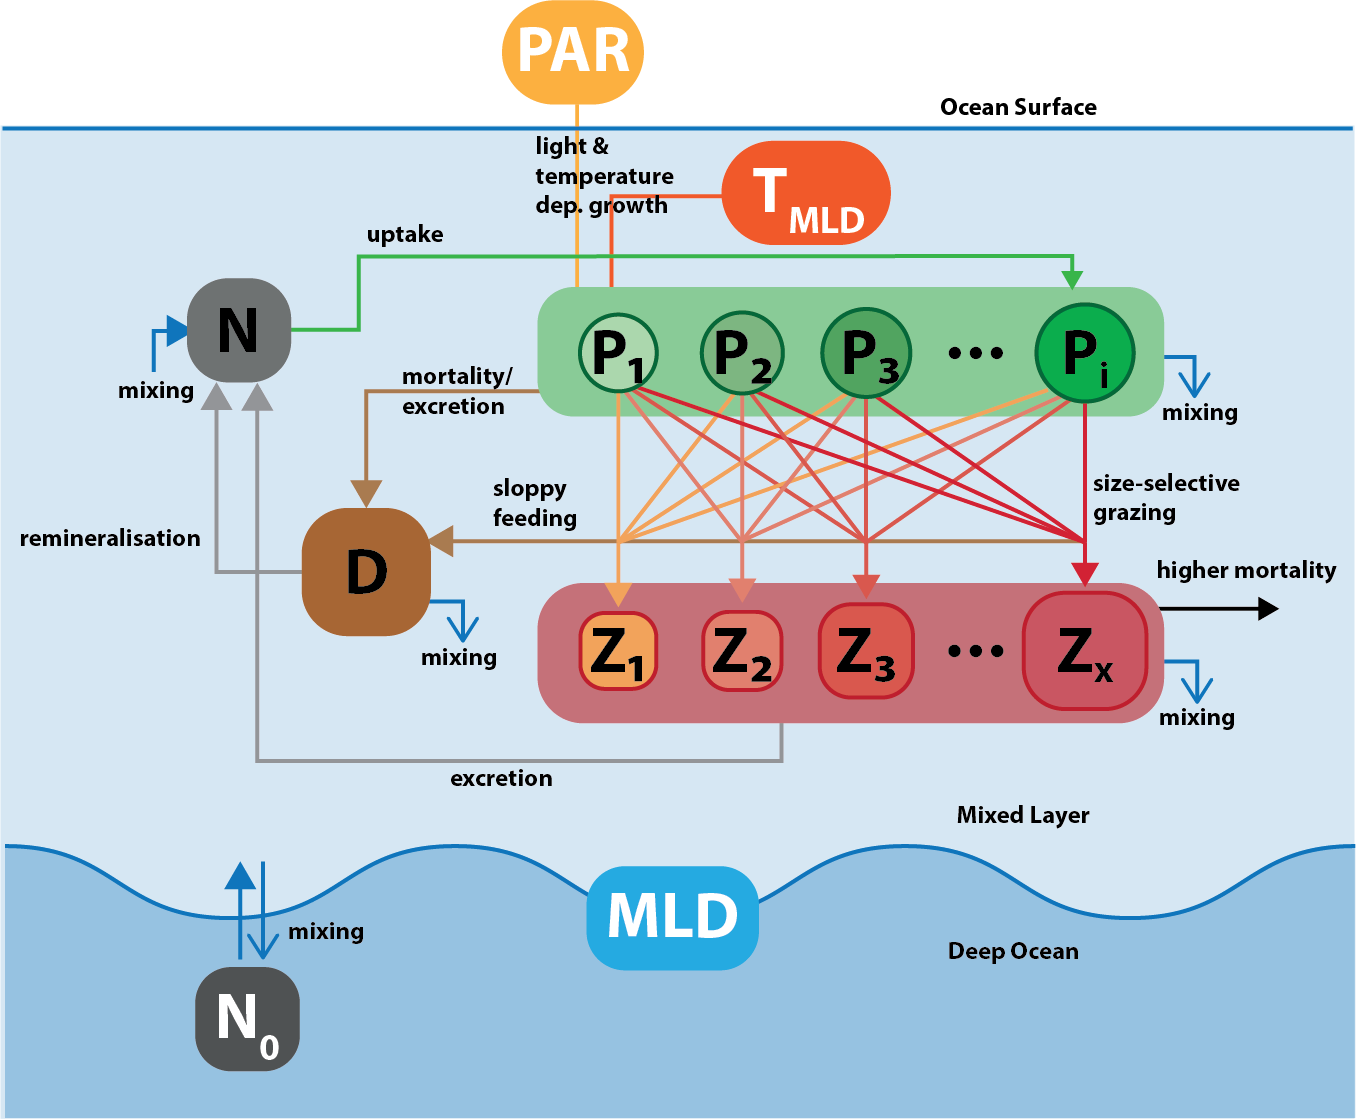

In [1]:
from IPython.display import Image
Image(filename=('NPxZxDslab_schematics.png'), width=500)

In [2]:
import numpy as np
# to check for array handling errors:
np.warnings.filterwarnings('error', category=np.VisibleDeprecationWarning)

import matplotlib.pyplot as plt

# Parameter helping functions (Size Arrays & Allometries)

In [3]:
PZ_num = 40

phyto_init = np.tile(.01, (PZ_num))

zoo_init = np.tile(.005, (PZ_num))

In [4]:
def calculate_sizes(size_min, size_max, num):
    """initializes log spaced array of sizes from ESD size range"""
    numbers = np.array([i for i in range(num)])
    sizes = (np.log(size_max) - np.log(size_min))* numbers / (num-1) + np.log(size_min)
    return np.exp(sizes)

In [5]:
phyto_sizes = calculate_sizes(2,200,PZ_num)
phyto_sizes

array([  2.        ,   2.25067117,   2.53276035,   2.85020534,
         3.20743749,   3.60944353,   4.06183524,   4.57092773,
         5.14382762,   5.78853225,   6.51404131,   7.33048247,
         8.24925277,   9.28317767,  10.44669015,  11.75603214,
        13.22948128,  14.88760603,  16.7535528 ,  18.8533691 ,
        21.2163671 ,  23.87553283,  26.86798665,  30.23550141,
        34.0250856 ,  38.28963952,  43.0886938 ,  48.48924034,
        54.56666753,  61.4058126 ,  69.10214589,  77.76310361,
        87.5095875 ,  98.47765263, 110.8204066 , 124.71014683,
       140.34076573, 157.93045737, 177.72476325, 200.        ])

In [6]:
zoo_sizes = calculate_sizes(20,400,PZ_num)
zoo_sizes

array([ 20.        ,  21.59681654,  23.32112424,  25.18310209,
        27.19374179,  29.36491263,  31.70943155,  34.24113879,
        36.97497964,  39.9270926 ,  43.1149047 ,  46.55723435,
        50.27440245,  54.28835233,  58.62277929,  63.30327048,
        68.35745596,  73.81517179,  79.70863616,  86.07263961,
        92.94475035, 100.3655361 , 108.37880352, 117.03185685,
       126.3757771 , 136.46572368, 147.36125995, 159.12670483,
       171.83151258, 185.55068268, 200.36520267, 216.36252619,
       233.63708925, 252.29086772, 272.43397929, 294.18533355,
       317.67333393, 343.03663568, 370.42496443, 400.        ])

In [7]:
def calculate_zoo_I0(sizes):
    """initializes allometric parameters based on array of sizes (ESD)"""
    return 26 * sizes ** -0.4 #* .5

zoo_I0 = calculate_zoo_I0(zoo_sizes)
zoo_I0

array([7.84442924, 7.60707069, 7.3768942 , 7.15368244, 6.93722467,
       6.72731654, 6.52375985, 6.32636242, 6.13493789, 5.94930553,
       5.76929008, 5.59472157, 5.4254352 , 5.26127114, 5.10207439,
       4.94769465, 4.79798617, 4.6528076 , 4.51202188, 4.37549608,
       4.24310132, 4.11471258, 3.99020866, 3.86947201, 3.75238864,
       3.638848  , 3.5287429 , 3.42196939, 3.31842665, 3.21801694,
       3.12064544, 3.02622023, 2.93465217, 2.84585479, 2.75974426,
       2.67623928, 2.59526102, 2.51673301, 2.44058113, 2.36673346])

In [8]:
def calculate_phyto_mu0(sizes):
    """initializes allometric parameters based on array of sizes (ESD)
    allometric relationships are taken from meta-analyses of lab data"""
    return 2.6 * sizes ** -0.45
    
phyto_mu0 = calculate_phyto_mu0(phyto_sizes)
phyto_mu0

array([1.9033114 , 1.80481598, 1.71141764, 1.62285262, 1.5388708 ,
       1.45923499, 1.3837203 , 1.31211345, 1.24421223, 1.17982486,
       1.1187695 , 1.06087373, 1.00597404, 0.95391538, 0.90455073,
       0.85774067, 0.81335301, 0.7712624 , 0.73134995, 0.69350295,
       0.65761451, 0.62358328, 0.59131316, 0.56071299, 0.53169637,
       0.50418135, 0.47809021, 0.45334928, 0.42988867, 0.40764215,
       0.38654687, 0.36654326, 0.34757482, 0.329588  , 0.31253198,
       0.29635861, 0.28102219, 0.26647943, 0.25268925, 0.23961271])

In [9]:
def calculate_phyto_ks(sizes):
    return sizes * .1

phyto_ks = calculate_phyto_ks(phyto_sizes)
phyto_ks

array([ 0.2       ,  0.22506712,  0.25327603,  0.28502053,  0.32074375,
        0.36094435,  0.40618352,  0.45709277,  0.51438276,  0.57885322,
        0.65140413,  0.73304825,  0.82492528,  0.92831777,  1.04466901,
        1.17560321,  1.32294813,  1.4887606 ,  1.67535528,  1.88533691,
        2.12163671,  2.38755328,  2.68679867,  3.02355014,  3.40250856,
        3.82896395,  4.30886938,  4.84892403,  5.45666675,  6.14058126,
        6.91021459,  7.77631036,  8.75095875,  9.84776526, 11.08204066,
       12.47101468, 14.03407657, 15.79304574, 17.77247633, 20.        ])

In [10]:
def init_phiP(phytosize, preyoptsize):
    """creates array of feeding preferences [P...P10] for each [Z]"""
    phiP = np.array([[np.exp(-((np.log10(xpreyi) - np.log10(xpreyoptj)) / 0.25) ** 2)
                      for xpreyi in phytosize] for xpreyoptj in preyoptsize])
    return phiP

phiP = init_phiP(phyto_sizes, phyto_sizes)
phiP

array([[1.00000000e+00, 9.58795394e-01, 8.45091543e-01, ...,
        9.61192639e-26, 4.09501841e-27, 1.60381089e-28],
       [9.58795394e-01, 1.00000000e+00, 9.58795394e-01, ...,
        2.07403887e-24, 9.61192639e-26, 4.09501841e-27],
       [8.45091543e-01, 9.58795394e-01, 1.00000000e+00, ...,
        4.11410362e-23, 2.07403887e-24, 9.61192639e-26],
       ...,
       [9.61192639e-26, 2.07403887e-24, 4.11410362e-23, ...,
        1.00000000e+00, 9.58795394e-01, 8.45091543e-01],
       [4.09501841e-27, 9.61192639e-26, 2.07403887e-24, ...,
        9.58795394e-01, 1.00000000e+00, 9.58795394e-01],
       [1.60381089e-28, 4.09501841e-27, 9.61192639e-26, ...,
        8.45091543e-01, 9.58795394e-01, 1.00000000e+00]])

# Model building

In [11]:
import os,sys,inspect
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import phydra

In [13]:
from phydra.components.variables import SV, SVArray

from phydra.components.fluxes.basic import LinearDecay, LinearExchange, QuadraticDecay, QuadraticExchange
from phydra.components.fluxes.basic_dims import (LinearDecay_Dims, LinearExchange_SourceDim, 
                                                 QuadraticDecay_Dim, QuadraticExchange_SourceDim)
from phydra.components.fluxes.growth_multi_lim import (Growth_ML_ConsumerDim, Eppley_ML_ConsumerDim, 
                                                       Monod_ML_ConsumerDim, Steele_ML_ConsumerDim)
from phydra.components.fluxes.grazing import (HollingTypeIII_ResourcesListInput_Consumption2Group,
                                              SizebasedGrazingKernel_Dims,
                                              GrossGrowthEfficiency_MatrixGrazing,
                                              GrossGrowthEfficiency)
from phydra.components.fluxes.ocean_physics import Mixing_K, SlabUpwelling_KfromGroup, SlabMixing_KfromGroup, SlabSinking

from phydra.components.forcings import GlobalSlabClimatologyForcing

In [14]:
NPxZxD = phydra.create({
    # State variables
    'Nutrient':SV,
    'Phytoplankton':SVArray,
    'Zooplankton':SVArray,
    'Detritus':SV,
    
    # Mixing:
    'K':Mixing_K,
    'Upwelling':SlabUpwelling_KfromGroup,
    'Mixing':SlabMixing_KfromGroup,
    'Sinking':SlabSinking,

    # Growth
    'Growth':Growth_ML_ConsumerDim,
    'Monod':Monod_ML_ConsumerDim,
    'Steele':Steele_ML_ConsumerDim,
    'Eppley':Eppley_ML_ConsumerDim,
    
    # Grazing
    'Grazing':SizebasedGrazingKernel_Dims,
    'GGE':GrossGrowthEfficiency_MatrixGrazing,
    
    # Mortality 
    'PhytoLinMortality':LinearExchange_SourceDim,
    'PhytoQuadMortality':QuadraticExchange_SourceDim,
    'ZooLinMortality':LinearExchange_SourceDim,
    'HigherOrderPred':QuadraticDecay_Dim,
    'DetRemineralisation':LinearExchange,

    # Forcings
    'N0':GlobalSlabClimatologyForcing,
    'Tmld':GlobalSlabClimatologyForcing,
    'I0':GlobalSlabClimatologyForcing,
    'MLD':GlobalSlabClimatologyForcing,
    'MLDderiv':GlobalSlabClimatologyForcing,
                     })

In [15]:
#NPxZxD.visualize()

In [16]:
NPxZxD

<xsimlab.Model (27 processes, 96 inputs)>
Core
    solver_type              [in]
Time
    time                     [in] ('input_time',) sequence of time ...
Nutrient
    var_label                [in] label / basic state variable
    var_init                 [in] initial value / basic state variable
Phytoplankton
    var_label                [in] label / basic state variable
    var_init                 [in] ('var',) initial value / basic st...
Zooplankton
    var_label                [in] label / basic state variable
    var_init                 [in] ('var',) initial value / basic st...
Detritus
    var_init                 [in] initial value / basic state variable
    var_label                [in] label / basic state variable
N0
    smooth                   [in] smoothing conditions, larger valu...
    rbb                      [in] constant value of forcing
    deriv                    [in] order of derivative to store, for...
    dataset                  [in] Options: 'n0x', 'mld', '

In [17]:
# Set common location of global slab forcing
forcing_location = {'lat':47,'lon':-20,'rbb':2}

odeint_setup = phydra.setup('odeint', NPxZxD,
            time=np.arange(0,365*10),  # *365
            input_vars={
                    # State variables
                    'Nutrient':{'var_label':'N','var_init':1.},
                    'Phytoplankton':{'var_label':'P','var_init':phyto_init},
                    'Zooplankton':{'var_label':'Z','var_init':zoo_init},
                    'Detritus':{'var_label':'D','var_init':1.},
                
                    # Mixing:
                    'K':{'mld':'MLD', 'mld_deriv':'MLDderiv', 'kappa':0.13},
                    'Upwelling':{'n':'N', 'n_0':'N0'},
                    'Mixing':{'vars_sink':['P','D']},
                    'Sinking':{'var':'D', 'mld':'MLD', 'rate':6.43},

                    # Growth
                    'Growth':{'consumer':'P', 'resource':'N', 'mu_max':1.,},
                    'Monod':{'resource':'N', 'halfsat':phyto_ks},
                    'Steele':{'pigment_biomass':'P','i_0':'I0', 'mld':'MLD',
                          'kw':0.04, 'kc':0.03, 'i_opt':10},
                    'Eppley':{'temp':'Tmld', 'eppley_exp':0.063},

                    # Grazing
                    'Grazing':{'resource':'P', 'consumer':'Z',
                               'Imax':zoo_I0, 'KsZ':3, 'phiP':phiP},
                    'GGE':{'grazed_resource':'P', 'assimilated_consumer':'Z', 'egested_detritus':'D', 
                           'epsilon':0.33, 'f_eg':0.33},

                    # Mortality & sinking
                    'PhytoLinMortality':{'source':'P', 'sink':'D', 'rate':0.1},
                    'PhytoQuadMortality':{'source':'P', 'sink':'D', 'rate':0.01},
                    'ZooLinMortality':{'source':'Z', 'sink':'D', 'rate':0.01},
                    'HigherOrderPred':{'var':'Z', 'rate':0.034},
                    'DetRemineralisation':{'source':'D', 'sink':'N', 'rate':0.1},

                    # Forcings
                    'N0':{**forcing_location, 'forcing_label':'N0', 'dataset':'n0x',
                          'smooth':5, 'k':2, 'deriv':0},
                    'Tmld':{**forcing_location, 'forcing_label':'Tmld', 'dataset':'tmld',
                          'smooth':5, 'k':2, 'deriv':0},
                    'I0':{**forcing_location, 'forcing_label':'I0', 'dataset':'par',
                          'smooth':10, 'k':2, 'deriv':0},
                    'MLD':{**forcing_location, 'forcing_label':'MLD', 'dataset':'mld',
                          'smooth':400, 'k':2, 'deriv':0},
                    'MLDderiv':{**forcing_location, 'forcing_label':'MLDderiv', 'dataset':'mld',
                          'smooth':400, 'k':2, 'deriv':1}
            },
            output_vars="ALL"
            )

In [18]:
with NPxZxD:
    odeint_out = odeint_setup.xsimlab.run()

initializing model backend
Initializing Model Time
Initializing component Nutrient
Initializing component Phytoplankton
Initializing component Zooplankton
Initializing component Detritus
Initializing component N0
Initializing component Tmld
Initializing component MLD
Initializing component I0
Initializing component MLDderiv
Initializing component K
Initializing component Monod
Initializing component Sinking
Initializing component Grazing
Initializing component ZooLinMortality
Initializing component DetRemineralisation
Initializing component Eppley
Initializing component PhytoQuadMortality
Initializing component Steele
Initializing component PhytoLinMortality
Initializing component HigherOrderPred
Initializing component Upwelling
Initializing component Mixing
Initializing component Growth
Initializing component GGE
assembling model
SOLVER : <phydra.backend.solvers.ODEINTSolver object at 0x1599d99a0>
Model is assembled:
Model contains: 
Variables:['time', 'N', 'P', 'Z', 'D'] 
Parameters:

In [21]:
odeint_out

<xarray.Dataset>
Dimensions:                           (clock: 2, consumer: 40, input_time: 3650, resource: 40, sinking_vars: 2, sinking_vars_full: 41, time: 3650, var: 40, vars: 40)
Coordinates:
  * clock                             (clock) int64 0 1
Dimensions without coordinates: consumer, input_time, resource, sinking_vars, sinking_vars_full, time, var, vars
Data variables:
    Core__solver_type                 <U6 'odeint'
    DetRemineralisation__decay_value  (time) float64 0.09515 ... 0.002083
    DetRemineralisation__rate         float64 0.1
    DetRemineralisation__sink         <U1 'N'
    DetRemineralisation__source       <U1 'D'
    Detritus__var_init                float64 1.0
    Detritus__var_label               <U1 'D'
    Detritus__var_value               (time) float64 1.0 0.9055 ... 0.02084
    Eppley__eppley_exp                float64 0.063
    Eppley__eppley_growth_label       <U20 'Eppley_eppley_growth'
    Eppley__eppley_growth_value       (time) float64 2.318 2.318 ... 2.333 2.328
    Eppley__temp                      <U4 'Tmld'
    GGE__assimilated_consumer         <U1 'Z'
    GGE__assimilation_value           (consumer, time) float64 0.0002218 ... 0.0
    GGE__egested_detritus             <U1 'D'
    GGE__egestion_value               (time) float64 0.008265 ... 4.387e-05
    GGE__epsilon                      float64 0.33
    GGE__f_eg                         float64 0.33
    GGE__grazed_resource              <U1 'P'
    GGE__grazing_value                (resource, time) float64 0.000636 ... 0.0
    Grazing__Imax                     (consumer) float64 7.844 7.607 ... 2.367
    Grazing__KsZ                      int64 3
    Grazing__consumer                 <U1 'Z'
    Grazing__grazing_label            <U15 'Grazing_grazing'
    Grazing__grazing_value            (resource, consumer, time) float64 0.00...
    Grazing__phiP                     (resource, consumer) float64 1.0 ... 1.0
    Grazing__resource                 <U1 'P'
    Growth__consumer                  <U1 'P'
    Growth__growth_value              (vars, time) float64 0.003637 ... 0.0
    Growth__mu_max                    float64 1.0
    Growth__resource                  <U1 'N'
    HigherOrderPred__decay_value      (var, time) float64 8.783e-07 ... 0.0
    HigherOrderPred__rate             float64 0.034
    HigherOrderPred__var              <U1 'Z'
    I0__dataset                       <U3 'par'
    I0__deriv                         int64 0
    I0__forcing_label                 <U2 'I0'
    I0__forcing_value                 (time) float64 7.521 7.594 ... 7.388 7.452
    I0__k                             int64 2
    I0__lat                           int64 47
    I0__lon                           int64 -20
    I0__rbb                           int64 2
    I0__smooth                        int64 10
    K__kappa                          float64 0.13
    K__mixing_label                   <U8 'K_mixing'
    K__mixing_value                   (time) float64 0.01196 0.01196 ... 0.01224
    K__mld                            <U3 'MLD'
    K__mld_deriv                      <U8 'MLDderiv'
    MLD__dataset                      <U3 'mld'
    MLD__deriv                        int64 0
    MLD__forcing_label                <U3 'MLD'
    MLD__forcing_value                (time) float64 160.4 162.2 ... 156.8 158.6
    MLD__k                            int64 2
    MLD__lat                          int64 47
    MLD__lon                          int64 -20
    MLD__rbb                          int64 2
    MLD__smooth                       int64 400
    MLDderiv__dataset                 <U3 'mld'
    MLDderiv__deriv                   int64 1
    MLDderiv__forcing_label           <U8 'MLDderiv'
    MLDderiv__forcing_value           (time) float64 1.818 1.78 ... 1.795 1.806
    MLDderiv__k                       int64 2
    MLDderiv__lat                     int64 47
    MLDderiv__lon                     int64 -20
    MLDderiv__rbb                     int64 2
    MLDderi

In [20]:
odeint_out.to_netcdf('test.nc')

NotImplementedError: variable None has a _FillValue specified, but _FillValue is not yet supported on unicode strings: https://github.com/pydata/xarray/issues/1647

In [ ]:
plt.rcParams['figure.figsize'] = [20, 5]

In [ ]:
plt.pcolor(odeint_out.Phytoplankton__var_value)
plt.colorbar()
plt.show()

In [ ]:
plt.pcolor(odeint_out.Zooplankton__var_value)
plt.colorbar()
plt.show()

In [ ]:
time = odeint_out.Time__time

plt.plot(time, odeint_out.MLD__forcing_value, label='MLD')
plt.ylim(bottom=0)
plt.legend()
plt.show()

plt.plot(time, odeint_out.MLDderiv__forcing_value, label='MLDderiv')
plt.legend()
plt.show()

plt.plot(time, odeint_out.I0__forcing_value, label='I0')
plt.plot(time, odeint_out.N0__forcing_value, label='N0')
plt.plot(time, odeint_out.Tmld__forcing_value, label='Tmld')
plt.ylim(bottom=0)
plt.legend()

In [ ]:
time = odeint_out.Time__time
plt.plot(time, odeint_out.Nutrient__var_value, label='N')
plt.ylim(bottom=0)
plt.legend()

In [ ]:
time = odeint_out.Time__time
plt.plot(time, odeint_out.Nutrient__var_value, label='N')
plt.plot(time, odeint_out.Phytoplankton__var_value.T, label='P')
plt.plot(time, odeint_out.Zooplankton__var_value.T, label='Z')
plt.plot(time, odeint_out.Detritus__var_value, label='D')
plt.ylim(bottom=0)
plt.legend()

In [ ]:
#plt.plot(time, -odeint_out.PhytoLinMortality__decay_value.T, label='P linear mortality')
#plt.plot(time, -odeint_out.PhytoQuadMortality__decay_value.T, label='P quad mortality')
plt.plot(time, odeint_out.Growth__growth_value.T, label='Phyto growth')

plt.legend()

In [ ]:
plt.plot(time, odeint_out.GGE__grazing_value.T, label="grazing")
plt.legend()

In [ ]:
stepwise_setup = phydra.update_setup(model=NPxZxD, old_setup=odeint_setup, new_solver="stepwise",
                                     new_time=np.arange(0,5*365,.2))

In [ ]:
with NPxZxD:
    stepwise_out = stepwise_setup.xsimlab.run()

In [ ]:
time = stepwise_out.Time__time
plt.plot(time, stepwise_out.Nutrient__var_value, label='N')
plt.plot(time, stepwise_out.Phytoplankton__var_value.T, label='P')
plt.plot(time, stepwise_out.Zooplankton__var_value.T, label='Z')
plt.plot(time, stepwise_out.Detritus__var_value, label='D')
#plt.ylim(bottom=0)
plt.legend()

In [ ]:
plt.plot(time, stepwise_out.GGE__grazing_value.T, label="grazing")
plt.legend()

#stepwise_out.GGE__egestion_value

In [ ]:
plt.plot(time, stepwise_out.GGE__assimilation_value[0,:], label="graze 1")
plt.plot(time, stepwise_out.GGE__assimilation_value[1,:], label="graze 2")
plt.plot(time, stepwise_out.GGE__assimilation_value[2,:], label="graze 3")
plt.legend()

In [ ]:
#plt.plot(time, stepwise_out.GGE__grazed_resource)

In [ ]:
# plt.plot(time, stepwise_out.Input__input_value, label='N_input')
# plt.plot(time, -stepwise_out.PhytoLinMortality__decay_value, label='P mortality')
# plt.plot(time, -stepwise_out.PhytoQuadMortality__decay_value, label='P quad mortality')
# plt.plot(time, stepwise_out.Growth__growth_value, label='N uptake')
plt.plot(time, stepwise_out.Grazing__grazing_value[0,0,:], label='Grazing')
plt.plot(time, stepwise_out.Grazing__grazing_value[1,1,:], label='Grazing1')
plt.plot(time, stepwise_out.Grazing__grazing_value[2,2,:], label='Grazing2')
# plt.ylim(bottom=0)
plt.legend()

In [ ]:
gekko_setup = phydra.update_setup(model=NPxZxD, 
                                  old_setup=odeint_setup, 
                                  new_solver="gekko", 
                                  # gekko solver works better (much faster) with smaller time steps:
                                  # new_time=np.arange(0,201,.1)
                                 )

In [ ]:
with NPxZxD:
    gekko_out = gekko_setup.xsimlab.run()

In [ ]:
gekko_out

In [ ]:
time = gekko_out.Time__time
plt.plot(time, gekko_out.Nutrient__var_value, label='N')
plt.plot(time, gekko_out.Phytoplankton__var_value.T, label='P')
plt.plot(time, gekko_out.Zooplankton__var_value.T, label='Z')
plt.plot(time, gekko_out.Detritus__var_value, label='D')
plt.ylim(bottom=0)
plt.legend()

In [ ]:
# GEKKO
time = gekko_out.Time__time
#plt.plot(time, gekko_out.Nutrient__var_value, label='N')

plt.plot(time, gekko_out.Upwelling__mixing_value, label='mixing')
plt.plot(time, gekko_out.MLDderiv__forcing_value/100, label='MLDderiv')
#plt.ylim(bottom=0)
plt.legend()

In [ ]:
_dims = ()

In [ ]:
f"{'(' + ','.join(_dims) + ')'}"

In [ ]:
upwelling1 = (gekko_out.N0__forcing_value - gekko_out.Nutrient__var_value) * (np.maximum(gekko_out.MLDderiv__forcing_value, 0) +gekko_out.Upwelling__kappa) /gekko_out.MLD__forcing_value

In [ ]:
plt.plot(time, upwelling1)

In [ ]:
plt.plot(time, np.maximum(gekko_out.MLDderiv__forcing_value, 0) +gekko_out.Upwelling__kappa, label='mixing')

In [ ]:
# ODEINT
plt.plot(time, odeint_out.Upwelling__mixing_value, label='mixing')

plt.plot(time, odeint_out.MLDderiv__forcing_value/100, label='MLDderiv')
plt.legend()

In [ ]:
time = gekko_out.Time__time
#plt.plot(time, gekko_out.Nutrient__var_value, label='N')

plt.plot(time, gekko_out.Phytoplankton__var_value.T, label='P')
plt.plot(time, gekko_out.MLDderiv__forcing_value, label='MLDderiv')
plt.ylim(bottom=0)
plt.legend()

In [ ]:
plt.plot(time, gekko_out.PhytoLinMortality__decay_value.T, label='P mortality')
plt.plot(time, gekko_out.PhytoQuadMortality__decay_value.T, label='P quad mortality')
plt.plot(time, gekko_out.Growth__growth_value.T, label='N uptake')
#plt.plot(time, gekko_out.Grazing__grazing_value, label='Grazing')
plt.ylim(bottom=0)
plt.legend()